## Computer Vision Simplified Trainer

This notebook is modified from the `00-computer-vision-trainer.ipynb` notebook and has the explanation text removed

The basic steps we'll take are:

1. Importing our collected, organized, and cleaned images
1. Fine-tune a pretrained neural network model to take images as inputs and output category labels
1. Examining our output and deciding if we're happy with the model

## STOP HERE, THIS IS THE BASE TRAINER, MAKE A COPY AND DO YOUR WORK THERE

Describe what you want to do for this training here:

Item Transforms:item_tfms=Resize(224, 'squish'),

Pre-Trained Model: 

Batch Size: 64

Validation Size: 0.2

Epochs: 2


## STEP 0: Ensure you are running this notebook within a Docker Container

In [1]:
path = '/workspace/data/lakota_data'

## STEP 1: Ensure you have spectrogram images

The cell below will let you know what directories and file numbers are available in `/workspace/data/lakota_data`. This value should be assigned in an earlier cell for the variable `path`.

In [2]:
import os

if not os.path.isdir(path):
    print(f"'{path}' is not a valid directory.")
else:
    print(f"Scanning directory: {path}\n")
    for entry in os.scandir(path):
        if entry.is_dir():
            subdir_path = entry.path
            file_count = sum(
                1 for item in os.scandir(subdir_path) if item.is_file()
            )
            print(f"{entry.name}/ — {file_count} files")

Scanning directory: /workspace/data/lakota_data

napciyunka_nine/ — 63 files
numpa_two/ — 60 files
sa/ — 60 files
sakowin_seven/ — 60 files
sakpe/ — 60 files
sapa/ — 60 files
takuni/ — 54 files
topa/ — 60 files
wanzi/ — 60 files
wikcemna/ — 63 files
yamni/ — 60 files
zaptan/ — 60 files
zi/ — 60 files


## Step 2: Train an initial model so that we clean our data

Choose a model. More information about pretrained models, and others that you may want to use instead of `resnet34.a1_in1k` can be found at  
[https://www.kaggle.com/code/jhoward/which-image-models-are-best](https://www.kaggle.com/code/jhoward/which-image-models-are-best).

In [3]:
from fastai.vision.all import *
import timm

The three cells below will support you in choosing a pre-trained model to use. If you're ok with using the default model of `resnet34.a1_in1k`, or already have one that you want to use, you can skip to the `DataBlock` cell.

In [4]:
timm.list_models(pretrained=True)

['aimv2_1b_patch14_224.apple_pt',
 'aimv2_1b_patch14_336.apple_pt',
 'aimv2_1b_patch14_448.apple_pt',
 'aimv2_3b_patch14_224.apple_pt',
 'aimv2_3b_patch14_336.apple_pt',
 'aimv2_3b_patch14_448.apple_pt',
 'aimv2_huge_patch14_224.apple_pt',
 'aimv2_huge_patch14_336.apple_pt',
 'aimv2_huge_patch14_448.apple_pt',
 'aimv2_large_patch14_224.apple_pt',
 'aimv2_large_patch14_224.apple_pt_dist',
 'aimv2_large_patch14_336.apple_pt',
 'aimv2_large_patch14_336.apple_pt_dist',
 'aimv2_large_patch14_448.apple_pt',
 'bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patc

In [5]:
timm.list_models('levit*', pretrained=True)

['levit_128.fb_dist_in1k',
 'levit_128s.fb_dist_in1k',
 'levit_192.fb_dist_in1k',
 'levit_256.fb_dist_in1k',
 'levit_384.fb_dist_in1k',
 'levit_conv_128.fb_dist_in1k',
 'levit_conv_128s.fb_dist_in1k',
 'levit_conv_192.fb_dist_in1k',
 'levit_conv_256.fb_dist_in1k',
 'levit_conv_384.fb_dist_in1k']

In [6]:
# Model name
model_name = 'levit_128.fb_dist_in1k'

# Create the model instance
model = timm.create_model(model_name, pretrained=True)

# Retrieve the default configuration
default_cfg = model.default_cfg
print(default_cfg)

{'url': '', 'hf_hub_id': 'timm/levit_128.fb_dist_in1k', 'architecture': 'levit_128', 'tag': 'fb_dist_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'fixed_input_size': True, 'interpolation': 'bicubic', 'crop_pct': 0.9, 'crop_mode': 'center', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'num_classes': 1000, 'pool_size': None, 'first_conv': 'stem.conv1.linear', 'classifier': ('head.linear', 'head_dist.linear')}


Whichever model you choose, ensure that the `item_tfms` resize value matches the `'input_size'` in the information above. For the `'resnet34.a1_in1k'` model, the input size is `(3, 224, 224)` and so we need to ensure that the value below for `item_tfms` is:  
  
`item_tfms=Resize(224, 'squish')`

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, 'squish'),
    batch_tfms=[]#We don't want to transform our spectrograms, leave this line alone
).dataloaders(path, bs=64)

**NOTE: The batch size above (set by `bs=50`) cannot be higher than the number of image files you have.**

If the batch size is too high, you will see an error for the cell below that says  
`ValueError: This DataLoader does not contain any batches`.  

Reduce the `bs` value above in order to overcome this issue.

If you feel the batch size is good, save it in the cell below, we will use this in the longer training.

In [8]:
bs = 64 #this should match the value you have in the DataLoader above.

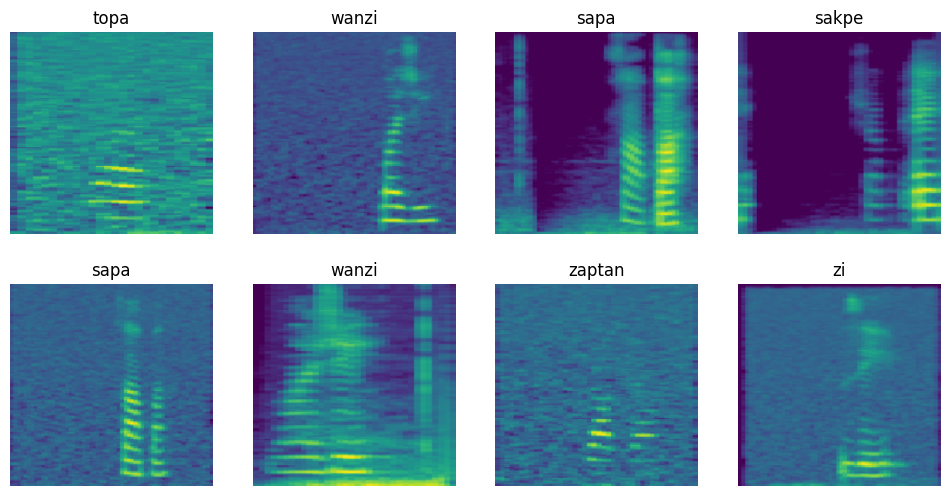

In [9]:
dls.show_batch(max_n=8, nrows=2, ncols=4)

In [10]:
learn = vision_learner(dls, model_name, metrics=error_rate)

Unexpected keys (head.bn.bias, head.bn.num_batches_tracked, head.bn.running_mean, head.bn.running_var, head.bn.weight, head_dist.bn.bias, head_dist.bn.num_batches_tracked, head_dist.bn.running_mean, head_dist.bn.running_var, head_dist.bn.weight) found while loading pretrained weights. This may be expected if model is being adapted.


SuggestedLRs(valley=0.0006918309954926372)

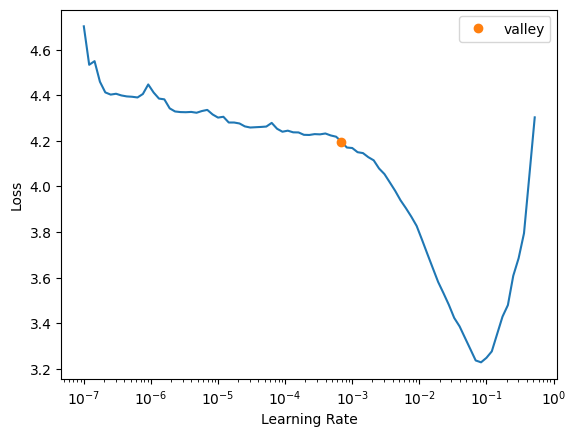

In [11]:
learn.lr_find() # find the learning rate

In [12]:
learning_rate = 0.0006918309954926372 # use the value from the lr_find() method above

In [13]:
initial_training_epochs = 2
learn.fine_tune(initial_training_epochs, base_lr=learning_rate) 

epoch,train_loss,valid_loss,error_rate,time
0,4.143396,3.692204,0.898089,00:34


epoch,train_loss,valid_loss,error_rate,time
0,4.001076,3.127357,0.872611,00:33
1,3.931896,3.039040,0.910828,00:35


The point of this initial training is to ensure that the longer model training below will work correctly.

**NOTE: If you get an error that states `RuntimeError: CUDA error: out of memory`, reduce the batch size value `bs=` in the `dataloaders()` parameters above.**

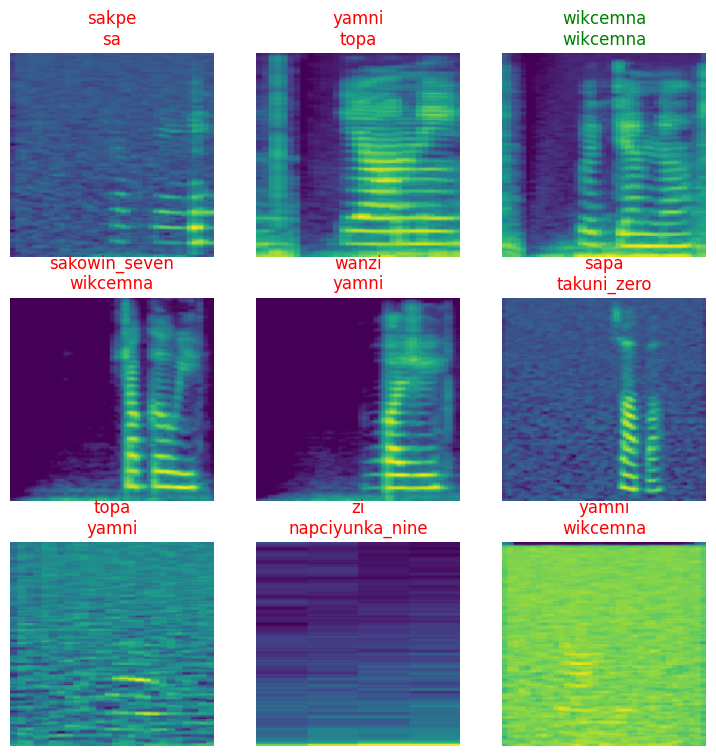

In [14]:
learn.show_results()

## Step 3: Let's see how our model did and what it had the most difficulty with

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

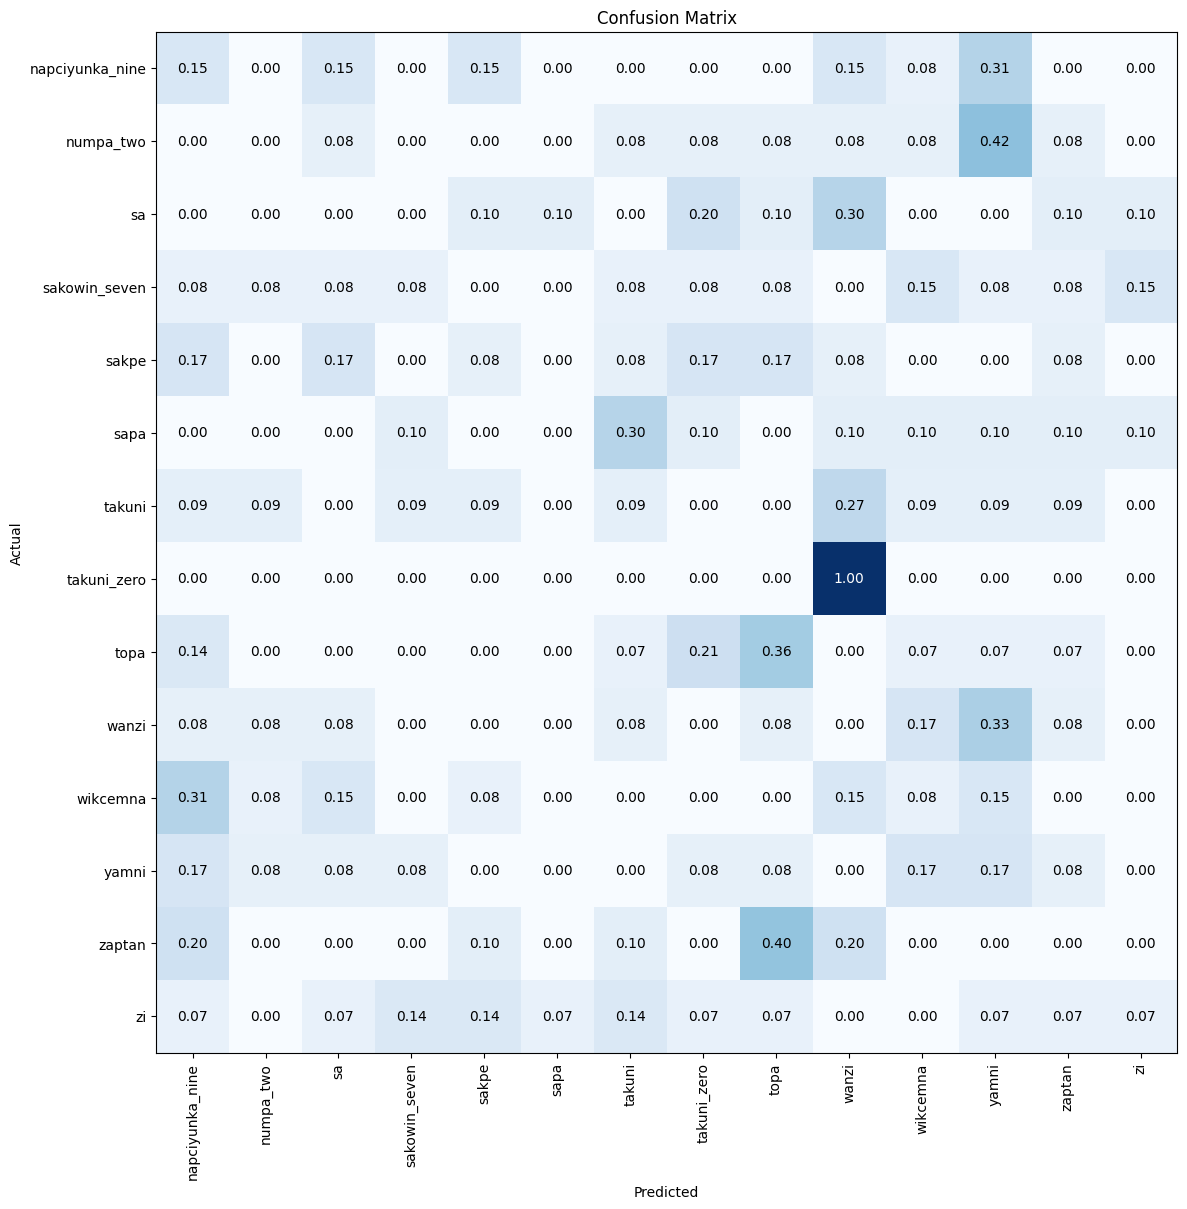

In [16]:
interp.plot_confusion_matrix(normalize=True, title='Confusion Matrix', figsize=(12, 12))

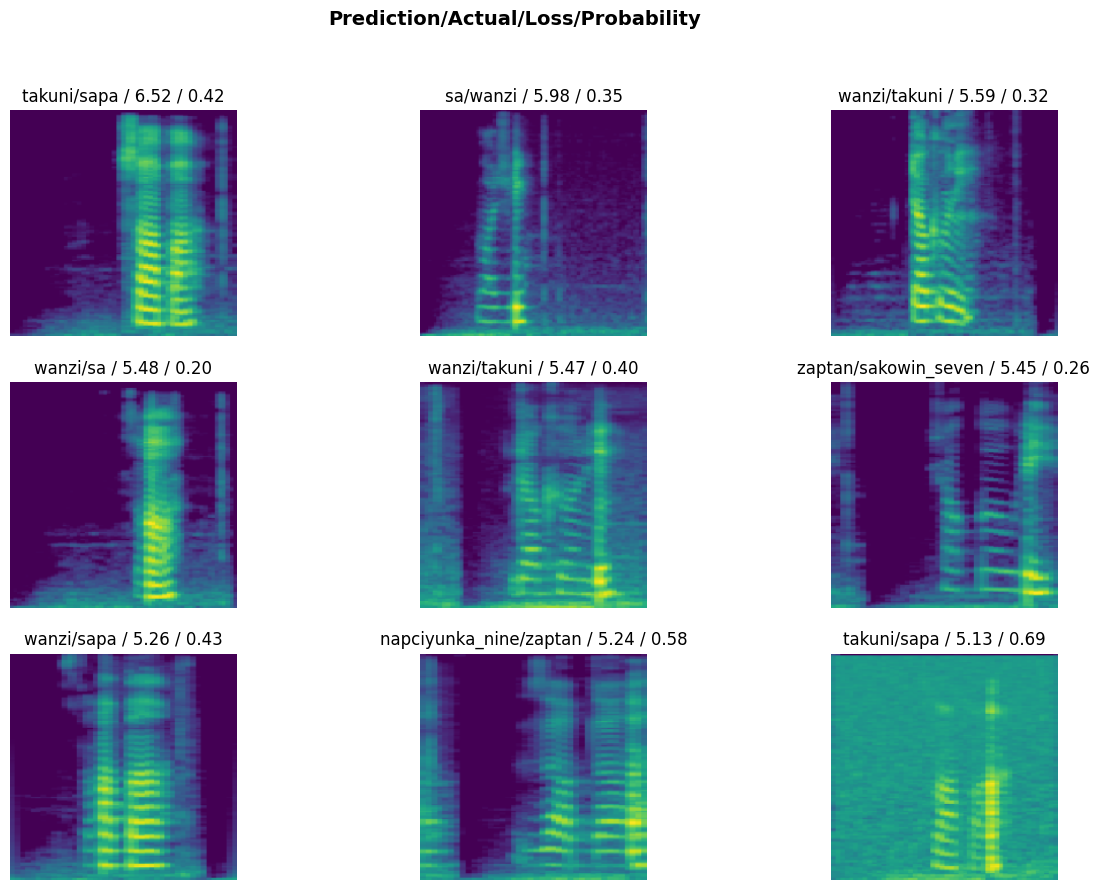

In [17]:
interp.plot_top_losses(9, figsize=(15,10))

## Step 4: Now We Train A Model Using What We've Learned

Set the parameter of your training

Naming convention: purpose_modelname_errorrate

What the model does?
What the model used?
How good is the model?

In [18]:

#first set how often the model should save a checkpoint file, these will be stored as .pth files, not .pkl
# not that .pth files will contain the model architecture, whereas .pkl files do not, which means .pth files are much larger in size

last_epoch_save = 0 # leave this value as zero if you are starting over from cleaned data

save_after_this_many_epochs = 5 # a .pth checkpoint file will be created every 5 epochs

model = model_name # this was set above

path = path # ensure this points to your data

# Define the number of additional epochs you want to train for

additional_epochs = 10  # Set the total number of epochs to run in the cell below

learning_rate = learning_rate # use the value from the lr_find() method above

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, 'squish'),#RandomResizedCrop(224, min_scale=0.3),
    batch_tfms=[]
).dataloaders(path, bs=bs)

In [19]:
from fastai.callback.core import Callback
from fastai.learner import load_learner
from fastai.data.core import DataLoaders

# SaveModelCallback will be triggered on each epoch, The default is 10 epochs, but you can set the amount using the save_after_this_many_epochs variable
class SaveModelCallback(Callback):
    def __init__(self, every=10, path='model', last_epoch_save=0):
        self.every = every
        self.path = path
        self.last_epoch_save = last_epoch_save

    def after_epoch(self):
        "Save the model every `self.every` epochs"
        if (self.epoch + 1) % self.every == 0:
            self.learn.save(f'{self.path}_epoch{self.epoch + (1+self.last_epoch_save)}')

# Define your data recover function, this function will return .pkl model from one of your checkpoint save files in the .pth format
# path = the path to your data (e.g. /workspace/data/TRAINING_DATA), path_to_pth_model = the path to your last saved .pth file
def recover_dl_from_pth(path, path_to_pth_model):
    dls = ImageDataLoaders.from_folder(path)
    learn = cnn_learner(dls, model) # be sure to use the same pretrained model here that you did for previous training, the model variable set above
    learn.load(path_to_pth_model)  # Load the model from the .pth file into the learn variable
    return learn # return the learn variable

# Load the previously trained model
recover_from_pth_file = False

if(recover_from_pth_file):
    # The code below will create a learner recovered from a checkpoint save
    # You will want to make sure that the pretrained model in recover_dl_from_pth() the same as what was used for fine tuning earlier
    learn_long = recover_dl_from_pth(path, '/workspace/models/model_epochEPOCH_NUM_HERE_TO_GET_TO_CORRECT_FLE.pth')
else:
    # This code will start at 0 or recover from a .pkl file
    if(last_epoch_save > 0):
        previous_model_path = '/workspace/models/MODEL_FILENAME.pkl'  # replace with your actual model path
        learn_long = load_learner(previous_model_path) #note that this is creating a different learner than the one we used above
    else:
        learn_long = vision_learner(dls, model, metrics=error_rate) # create the learner
    # Ensure data loaders are set up
    learn_long.dls = dls # path is the path to our data, which was set earlier

# Instantiate the custom callback
# modify last_epoch_save to be the number of epochs the model was trained up to
save_model_callback = SaveModelCallback(every=save_after_this_many_epochs, path='/workspace/models/model', last_epoch_save = last_epoch_save)

# Continue training the model with the custom callback
learn_long.fine_tune(additional_epochs, base_lr=learning_rate, cbs=[save_model_callback])

# Save the updated model at the end
updated_model_path = f'/workspace/models/model_epoch{(last_epoch_save+additional_epochs)}.pkl'
learn_long.export(updated_model_path)

print("Training completed and model saved.")


Unexpected keys (head.bn.bias, head.bn.num_batches_tracked, head.bn.running_mean, head.bn.running_var, head.bn.weight, head_dist.bn.bias, head_dist.bn.num_batches_tracked, head_dist.bn.running_mean, head_dist.bn.running_var, head_dist.bn.weight) found while loading pretrained weights. This may be expected if model is being adapted.


epoch,train_loss,valid_loss,error_rate,time
0,4.268822,3.684567,0.929936,00:34


epoch,train_loss,valid_loss,error_rate,time
0,3.973085,3.329196,0.917197,00:37
1,3.994188,3.117328,0.942675,00:39
2,3.918057,2.845078,0.859873,00:36
3,3.804083,10.120343,0.821656,00:39
4,3.715776,24.944599,0.802548,00:33
5,3.540749,34.028732,0.783440,00:37
6,3.426511,25.439552,0.757962,11:08
7,3.345719,19.376497,0.764331,00:46
8,3.270176,15.383311,0.751592,00:44
9,3.202262,9.251899,0.757962,00:44


Training completed and model saved.


In [ ]:
interp_long = ClassificationInterpretation.from_learner(learn_long)
interp_long.plot_confusion_matrix(normalize=True, title='Confusion Matrix', figsize=(12, 12))